In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
import mpl_axes_aligner

import seaborn as sns
import zipfile
from cycler import cycler

pd.options.display.float_format = '{:.4f}'.format


# global plotting settings
plt.style.use(['ggplot'])

default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'axes.labelcolor' : 'black',
                     'yaxis.labellocation' : 'center',
                     'lines.marker' : '.',
                     'lines.linestyle' : 'None',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (10*1.8, 5.65*1.8),
                     'mathtext.default' : 'regular'
                    })

# plt.rc('axes', prop_cycle=default_cycler)

data_dir = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/'

def read_l3(filepath, datecol='DATE'):
    df = (pd.read_csv(filepath, header=0, low_memory=False)
      .replace(-9999, np.nan).replace(99999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x[datecol]))
      .set_index('date', drop=False)
     )
    df.index = df.index.set_names(None)
    return df

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25.csv'
l3 = read_l3(filepath)

predictors = 'baseflux'
filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'
rf = read_l3(filepath).add_suffix('_RF')

filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/ann_predictors_laplace.csv'
ann = read_l3(filepath).add_suffix('_ANN')

l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':], ann.loc[:,'FCH4_F_ANN':]], axis=1)
# l3.to_csv('./output/csv/ATMOS_L3_{datetime.now().strftime("%Y%m%d")}_ch4gapfilled.csv', index = False)

platt_constant = rf['FCH4_F_UNCERTAINTY_RF'] / rf.loc[:, [f'FCH4_F{i}_RF' for i in range(1,11)]].std(axis=1)
# (platt_constant)

In [3]:
# output L3 fluxes with ch4 gap filling

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25_fluxgapfill.csv'
l3 = read_l3(filepath)

predictors = 'baseflux'
filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'
rf = read_l3(filepath).add_suffix('_RF')

filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/ann_predictors_laplace.csv'
ann = read_l3(filepath).add_suffix('_ANN')

l3 = pd.concat([l3, rf.loc[:,'FCH4_F_RF':], ann.loc[:,'FCH4_F_ANN':]], axis=1)
l3.to_csv(f'./output/csv/ATMOS_L3_{datetime.now().strftime("%Y-%m-%d")}_ch4gapfilled.csv', index = False)

## Annual metrics

In [2]:
cols = ['TA_EP','T60','Tsoil_mean','SWC_mean','Precip']

annualmet = l3[cols].agg(['mean', 'min', 'max'])
annualmet.loc['sum', 'Precip'] = l3.loc[:, 'Precip'].sum()
annualmet.loc['std', ['TA_EP', 'T60', 'Tsoil_mean', 'SWC_mean']] = l3.loc[:, ['TA_EP', 'T60', 'Tsoil_mean', 'SWC_mean']].std()
# mean and standard deviation of TA_EP, mean and ReddyProc unc of co2_flux, mean and gap-fill unc of FCH4

# annualmet.loc['uncertainty', :] = annualmet.std()
# annualmet.loc['uncertainty', ['NEE_f','co2_flux','FCH4_f','FCH4_F_RF']] = np.NaN

annualmet

,TA_EP,T60,Tsoil_mean,SWC_mean,Precip
mean,12.5219,12.0268,11.5006,0.3027,0.1156
min,-23.1185,-18.4000,1.6865,0.1573,0.0000
max,36.6963,34.8000,22.7450,0.4286,67.3000
sum,NaN,NaN,NaN,NaN,810.8000
std,11.7231,10.8633,7.2354,0.0819,NaN


In [3]:
cols = [f'FCH4_F{i}_RF' for i in range(1,11)]
model_sum = l3.loc[:, cols].sum(axis=0) * 1800 / 1000 / 1000 * 12.01
ch4_budget = [model_sum.mean(), model_sum.std() * 1.4210]
ch4_budget
# model_sum

[-0.3816044614926144, 3.0614157890823375]

In [4]:
ustars = l3.loc[:, 'ustar_thr'].unique()
ustars

array([0.14981061, 0.194696  ])

In [5]:
cols = ['ch4_flux', 'co2_flux', 'h2o_flux', 'NEE_f', 'FCH4_F_RF']
data_coverage = l3[cols].count()/l3.shape[0]
data_coverage

ch4_flux    0.3674
co2_flux    0.5446
h2o_flux    0.5681
NEE_f       1.0000
FCH4_F_RF   1.0000
dtype: float64

In [6]:
umoltogC = 1800 / 1000 / 1000 * 12.01 # [umol m-2 s-1] * (s 30min-1) / (umol mmol-1) / (mmol mol-1) * (gC molC-1)
umoltomgC = 1800 / 1000 * 12.01 # [umol m-2 s-1] * (s 30min-1) / (umol mmol-1) * (mgC mmolC-1)
cols = ['ch4_flux','FCH4_f', 'FCH4_F_ANN', 'FCH4_F_RF', 'co2_flux', 'NEE_f', 'GPP_f', 'Reco']
budget = l3[cols] * umoltogC
budget = budget.sum(axis=0)
budget['H_f'] = l3['H_f'].sum() / 1000
budget['LE_f'] = l3['LE_f'].sum() / 1000
# budget['NEE_%grow'] = l3.loc['2022-06':'2022-09-01', 'NEE_f'].sum()
budget['FCH4_uptake'] = l3.loc[l3['FCH4_F_RF']<0, 'FCH4_F_RF'].sum() * umoltogC
budget['FCH4_emission'] = l3.loc[l3['FCH4_F_RF']>0, 'FCH4_F_RF'].sum() * umoltogC
budget['FCH4_uptake%'] = budget['FCH4_uptake'] / (abs(budget['FCH4_uptake']) + abs(budget['FCH4_emission']))
budget['FCH4_emission%'] = budget['FCH4_emission'] / (abs(budget['FCH4_uptake']) + abs(budget['FCH4_emission']))
budget['FCH4_co2eq'] = budget['FCH4_F_RF'] / 12.01 * 16.04 * 45
budget['FCH4_co2eq_up'] = budget['FCH4_uptake'] / 12.01 * 16.04 * 45
budget['FCH4_co2eq_emit'] = budget['FCH4_emission'] / 12.01 * 16.04 * 45
budget['NEE_co2eq'] = budget['NEE_f'] / 12.01 * 44.01 # gC to molC, molC to gCO2
budget['rad_balance'] = (budget['FCH4_co2eq_up']) + (budget['FCH4_co2eq_emit']) + budget['NEE_co2eq']
# pd.concat([budget, pd.DataFrame({'rad_balance': budget['FCH4_F_RF'] * 45 + budget['NEE_f'], 
#                                  'ch4_to_0rad': budget['NEE_f'] / 45})])
budget['ch4_to_0rad'] = -(budget['NEE_co2eq'] / 45 / 16.04 * 12.01) # gCO2eq to gCH4, gCH4 to molC, molC to gC  
budget

ch4_flux            -0.3512
FCH4_f              -0.5024
FCH4_F_ANN        -550.6893
FCH4_F_RF           -0.3816
co2_flux          -356.7822
NEE_f              -18.5232
GPP_f             1804.8325
Reco              1786.3092
H_f                199.8094
LE_f               859.9817
FCH4_uptake         -1.8768
FCH4_emission        1.4952
FCH4_uptake%        -0.5566
FCH4_emission%       0.4434
FCH4_co2eq         -22.9344
FCH4_co2eq_up     -112.7970
FCH4_co2eq_emit     89.8626
NEE_co2eq          -67.8774
rad_balance        -90.8118
ch4_to_0rad          1.1294
dtype: float64

In [7]:
(18.5/12.01*44.01)

67.79225645295587

In [8]:
weekly = l3.groupby(l3.date.dt.to_period('W')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                   ).reset_index().set_index('date')
# weekly.index = weekly.index.set_names(None)

monthly = l3.groupby(l3.date.dt.to_period('M')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), # nmol m-2 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                   ).reset_index().set_index('date')
# monthly.index = monthly.index.set_names(None)

# # cols = ['FC', 'NEE_f', 'Reco', 'GPP_f', 'FCH4', 'FCH4_f', 'H_f'] # Fluxnet variables
# cols = ['co2_flux', 'NEE_f', 'Reco', 'GPP_f', 'ch4_flux', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN', 'LE', 'LE_f','H_f'] # Full output variables

# dailysum = l3.loc[:, cols].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
# dailysum.loc[:, 'LE_f'] = l3.loc[:, ['LE_f']].groupby(pd.Grouper(freq='1D')).sum()

# daily = l3.loc[:, cols].groupby(l3.index.floor('D')).mean()
# # daily[['FCH4', 'FCH4_f', 'FCH4_F_ANN']]
# # daily.loc[:,'FCH4']
# daily

daily = l3.groupby(l3.date.dt.to_period('D')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), # nmol m-2 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                 ).reset_index().set_index('date')

hourly = l3.groupby(l3.date.dt.to_period('H')).agg(TA_EP_mean = ('TA_EP', np.mean),
                                                  Tsoil_mean=('Tsoil_mean', np.mean), 
                                                  SWC_mean=('SWC_mean', np.mean), 
                                                  FCH4_F_RF_mean=('FCH4_F_RF', lambda x: np.mean(x * 1000)), # nmol m-2 
                                                   NEE_f_mean=('NEE_f', np.mean), 
                                                   GPP_f_mean=('GPP_f', np.mean), 
                                                   Reco_mean=('GPP_f', np.mean),
                                                  FCH4_F_RF_sum=('FCH4_F_RF', lambda x: np.sum(x * 1800 / 1000 * 12.01)), # mgC m-2
                                                   NEE_f_sum=('NEE_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                   GPP_f_sum=('GPP_f', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2 
                                                   Reco_sum=('Reco', lambda x: np.sum(x * 1800 / 1000 / 1000 * 12.01)), # gC m-2
                                                  H_f_sum=('H_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                  LE_f_sum=('LE_f', lambda x: np.sum(x / 1000)), # W m-2 to kW m-2
                                                   Precip_sum=('Precip', np.sum)
                                                 ).reset_index().set_index('date')

In [9]:
daily.loc['2022-11':'2023-02','LE_f_sum'].max()

2.1358680826686793

In [10]:
output = monthly.drop(columns=['GPP_f_mean', 'Reco_mean'])
# output.to_csv('./output/thesis/monthly_metrics.csv', index = True)

## Figure: Flux vs Ustar

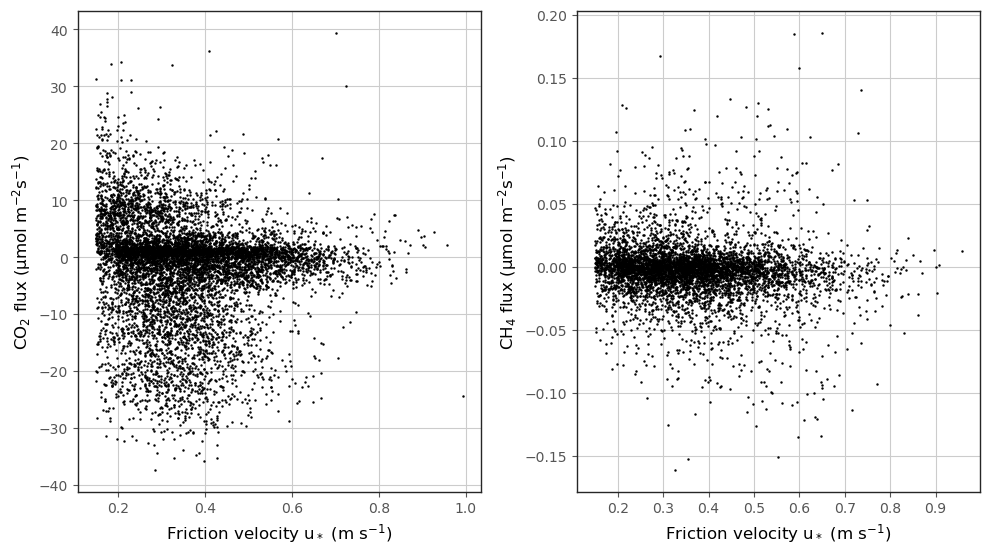

In [21]:
fig, ax = plt.subplots(1,2, figsize = (10, 5.65))

point_marker_style = dict(color='k', ls='',
                         markersize = 1.5)
xlabels = 'Friction velocity $u_*$ (m $s^{-1}$)'

ax[0].plot(l3.loc[:, 'u.'], l3.loc[:, 'co2_flux'], **point_marker_style)
ax[0].set(ylabel = r'$CO_2$ flux ($\mu$mol $m^{-2}s^{-1}$)', xlabel = xlabels)

ax[1].plot(l3.loc[:, 'u.'], l3.loc[:, 'ch4_flux'], **point_marker_style)
ax[1].set(ylabel = r'$CH_4$ flux ($\mu$mol $m^{-2}s^{-1}$)', xlabel = xlabels)


plt.tight_layout()
# plt.savefig(f'./output/thesis/fig_FvsUstar_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

## Figure: Environmental Conditions

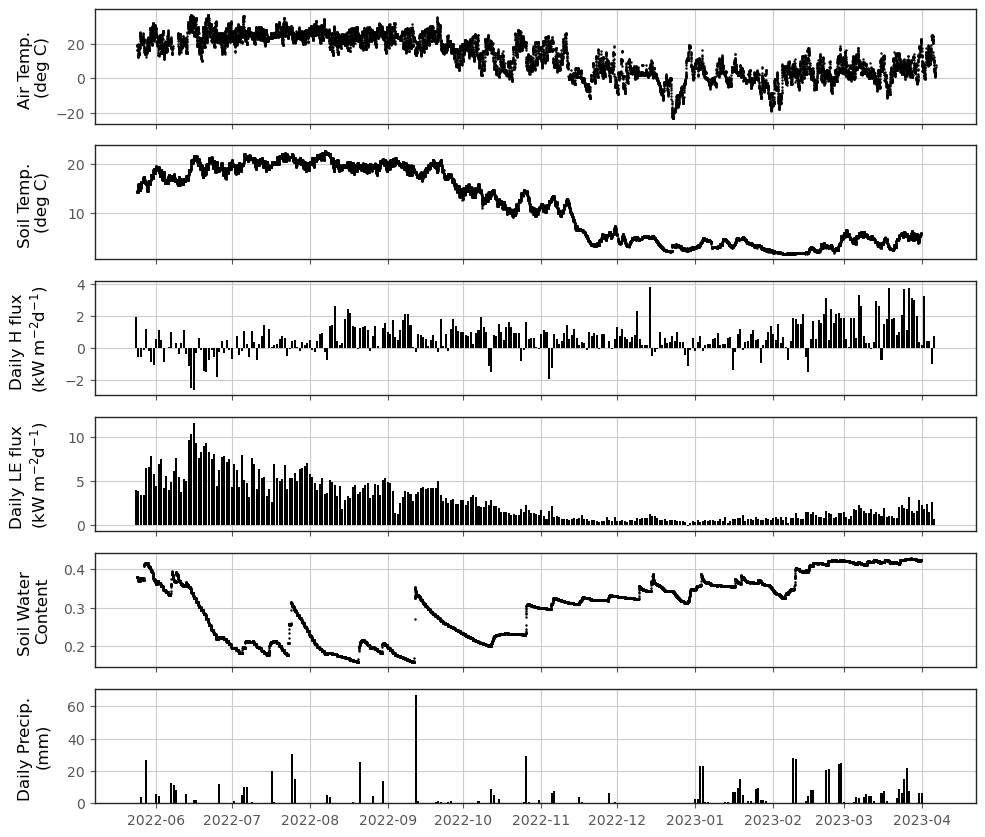

In [23]:
cols = ['TA_EP', 'Tsoil_mean', 'H_f_sum', 'LE_f_sum', 'SWC_mean', 'Precip_sum']
labels = ['Air Temp. \n(deg C)', 
          'Soil Temp. \n(deg C)', 
          'Daily H flux \n(kW $m^{-2}d^{-1}$)', 
          'Daily LE flux \n(kW $m^{-2}d^{-1}$)', 
          'Soil Water \nContent', 'Daily Precip. \n(mm)']
fig, ax = plt.subplots(len(cols),1, figsize = (10, 5.65*1.5), sharex = True)

point_marker_style = dict(color='k', ls='',
                         markersize = 1.5)

ax[0].plot(l3[cols[0]], **point_marker_style)
ax[1].plot(l3[cols[1]], **point_marker_style)
ax[2].bar(daily.index.to_timestamp(), daily[cols[2]], color = 'k')
ax[3].bar(daily.index.to_timestamp(), daily[cols[3]], color = 'k')
ax[4].plot(l3[cols[4]], **point_marker_style)
ax[5].bar(daily.index.to_timestamp(), daily[cols[5]], color = 'k')

for i in range(len(ax)):
    ax[i].set(ylabel = labels[i])
# ax[0].set(ylabel = labels[0] + '\n')
# ax[1].set(ylabel = labels[1] + '\n(deg C)')
# ax[2].set(ylabel = labels[2] + '\n(W $m^{-2}$)')
# ax[3].set(ylabel = labels[3] + '\n(W $m^{-2}$)')
# ax[4].set(ylabel = labels[4], xlabel = 'date')

# rax = ax[4].twinx()
# rax.bar(hourly.index.to_timestamp(), 
#         height=hourly['Precip_sum'], width=0.4, color = '#777777')
# rax.grid(visible=False)
# ax[4].grid(visible=False)
# mpl_axes_aligner.align.yaxes(ax[4], 0, rax, 0)

plt.tight_layout()

fig.align_ylabels(ax[:])
# plt.savefig(f'./output/thesis/fig_environ_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

## Figure: Plot carbon flux daily sums

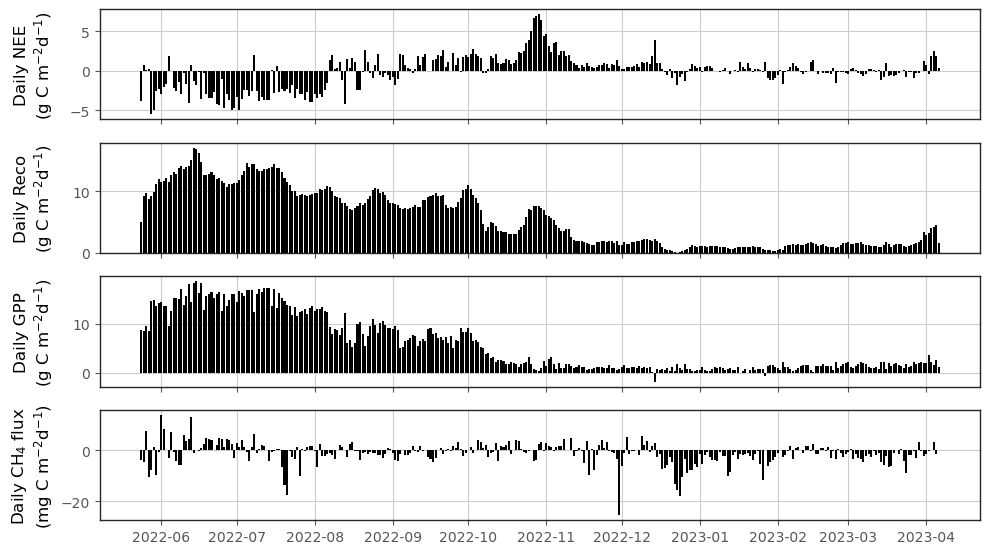

In [188]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f_sum', 'Reco_sum', 'GPP_f_sum', 'FCH4_F_RF_sum']
labels = ['Daily NEE', 'Daily Reco', 'Daily GPP', 'Daily $CH_4$ flux']
fig, ax = plt.subplots(len(cols),1, figsize = (10, 5.65), sharex = True)

for i in range(len(cols)):
    ax[i].bar(daily.index.to_timestamp(), daily[cols[i]], color = 'k', linestyle = 'None')
    if i == 3:
        ax[i].set(ylabel = labels[i] + '\n(mg C $m^{-2}d^{-1}$)')
    else: ax[i].set(ylabel = labels[i] + '\n(g C $m^{-2}d^{-1}$)')
    
# ax[1].set(ylim = [-150,1650])
# ax[2].set(ylim = [-150,1650])
plt.tight_layout()
fig.align_ylabels(ax[:])

plt.savefig(f'./output/thesis/fig_fluxes_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)


## Figure: Plot daily means over hours/half-hours

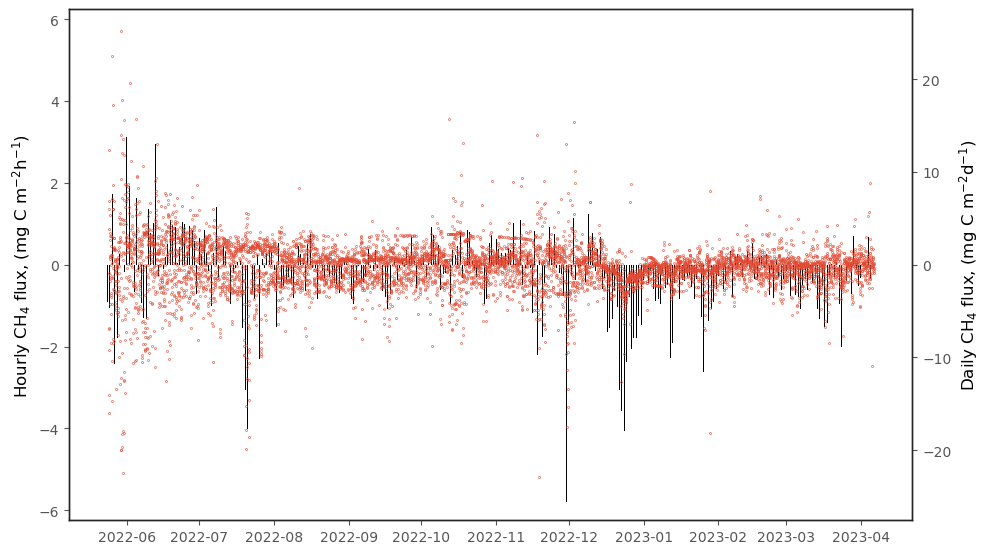

In [183]:
fig, ax = plt.subplots(1,1,figsize=(10, 5.65))
rax = ax.twinx()

ax.grid(visible=False)
rax.grid(visible=False)

ax.patch.set_facecolor('none')
rax.bar(x=daily.index.to_timestamp(), height=daily['FCH4_F_RF_sum'], 
        width=0.4, 
        color = 'k')
rax.set_ylabel(r'Daily $CH_4$ flux, (mg C $m^{-2}d^{-1}$)')

ax.plot(hourly.index.to_timestamp(), hourly['FCH4_F_RF_sum'], 
        marker = 'o', 
        fillstyle='none', 
        alpha = 0.8, 
        ms = 1.5,
        markeredgewidth=0.5,
        markerfacecolor='k',
#         markerfacecolor='tab:blue',
#         markerfacecoloralt='lightsteelblue',
#         markeredgecolor='k',
#         color = 'k',
        ls = '')
ax.set_ylabel(r'Hourly $CH_4$ flux, (mg C $m^{-2}h^{-1}$)')

# ax.plot(l3['FCH4_F_RF'] * 1800 / 1000 * 12.01, alpha = 1, ms = 1, ls = '', color = 'k')
# ax.set_ylabel(r'$CH_4$ flux, (mg C $m^{-2}$ 30 min$^{-1}$)')

rax.set_zorder(0)
ax.set_zorder(3)
mpl_axes_aligner.align.yaxes(ax, 0, rax, 0, 0.5)
plt.tight_layout()
# plt.savefig(f'./output/thesis/fig_ch4flux_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

In [191]:
plt.rcParams['axes.prop_cycle']

'#E24A33','-'
'#348ABD','--'
'#988ED5',':'
'#777777','-.'


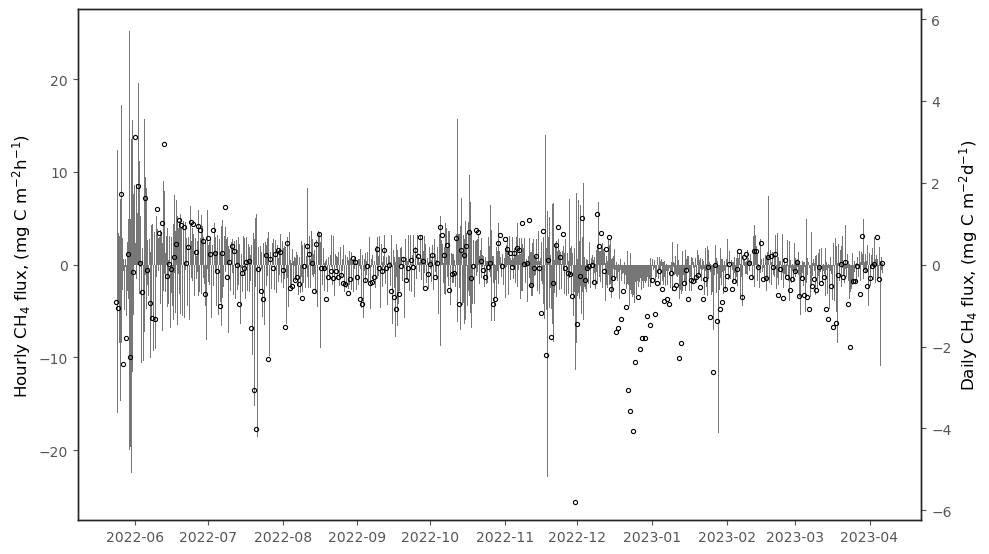

In [223]:
fig, ax = plt.subplots(1,1,figsize=(10, 5.65))
rax = ax.twinx()

ax.grid(visible=False)
rax.grid(visible=False)

ax.patch.set_facecolor('none')
rax.bar(x=hourly.index.to_timestamp(), height=hourly['FCH4_F_RF_sum'], 
        width=0.2, 
        color = '#777777')
rax.set_ylabel(r'Daily $CH_4$ flux, (mg C $m^{-2}d^{-1}$)')

dash_marker_style = dict(marker = '_', 
        ms = 4,
        markeredgewidth=1.2,
        color = 'k',
        ls = '')

point_marker_style = dict(marker = 'o', 
        fillstyle='none', 
        alpha = 1, 
        ms = 3,
        markeredgewidth=0.8,
        markerfacecolor='k',
#         markeredgecolor='k',
        color = 'k',
        ls = '')

ax.plot(daily.index.to_timestamp(), daily['FCH4_F_RF_sum'], **point_marker_style)
ax.set_ylabel(r'Hourly $CH_4$ flux, (mg C $m^{-2}h^{-1}$)')

# ax.plot(l3['FCH4_F_RF'] * 1800 / 1000 * 12.01, alpha = 1, ms = 1, ls = '', color = 'k')
# ax.set_ylabel(r'$CH_4$ flux, (mg C $m^{-2}$ 30 min$^{-1}$)')

rax.set_zorder(0)
ax.set_zorder(3)
mpl_axes_aligner.align.yaxes(ax, 0, rax, 0, 0.5)
plt.tight_layout()
# plt.savefig(f'./output/thesis/fig_ch4flux_{datetime.now().strftime("%Y%m%d")}_reversed.png', dpi=300)

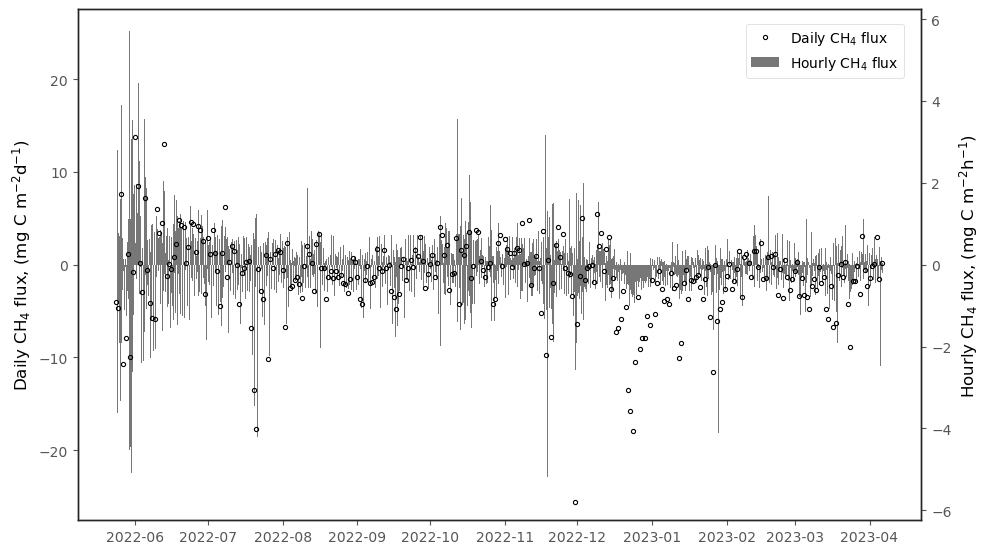

In [21]:
## EDIT 2023/10/31 add legend

fig, ax = plt.subplots(1,1,figsize=(10, 5.65))
rax = ax.twinx()

ax.grid(visible=False)
rax.grid(visible=False)

ax.patch.set_facecolor('none')
rax.bar(x=hourly.index.to_timestamp(), height=hourly['FCH4_F_RF_sum'], 
        width=0.2, 
        color = '#777777', label = r'Hourly $CH_4$ flux')
rax.set_ylabel(r'Hourly $CH_4$ flux, (mg C $m^{-2}h^{-1}$)')

dash_marker_style = dict(marker = '_', 
        ms = 4,
        markeredgewidth=1.2,
        color = 'k',
        ls = '')

point_marker_style = dict(marker = 'o', 
        fillstyle='none', 
        alpha = 1, 
        ms = 3,
        markeredgewidth=0.8,
        markerfacecolor='k',
#         markeredgecolor='k',
        color = 'k',
        ls = '')

ax.plot(daily.index.to_timestamp(), daily['FCH4_F_RF_sum'], 
        label = r'Daily $CH_4$ flux', **point_marker_style)
ax.set_ylabel(r'Daily $CH_4$ flux, (mg C $m^{-2}d^{-1}$)')

# ax.plot(l3['FCH4_F_RF'] * 1800 / 1000 * 12.01, alpha = 1, ms = 1, ls = '', color = 'k')
# ax.set_ylabel(r'$CH_4$ flux, (mg C $m^{-2}$ 30 min$^{-1}$)')

rax.set_zorder(0)
ax.set_zorder(3)
mpl_axes_aligner.align.yaxes(ax, 0, rax, 0, 0.5)
fig.legend(loc='upper center', bbox_to_anchor=(0.83, 0.96))
plt.tight_layout()
# plt.savefig(f'./output/thesis/fig_ch4flux_{datetime.now().strftime("%Y%m%d")}_reversed.png', dpi=300)

## Pre-thesis plots

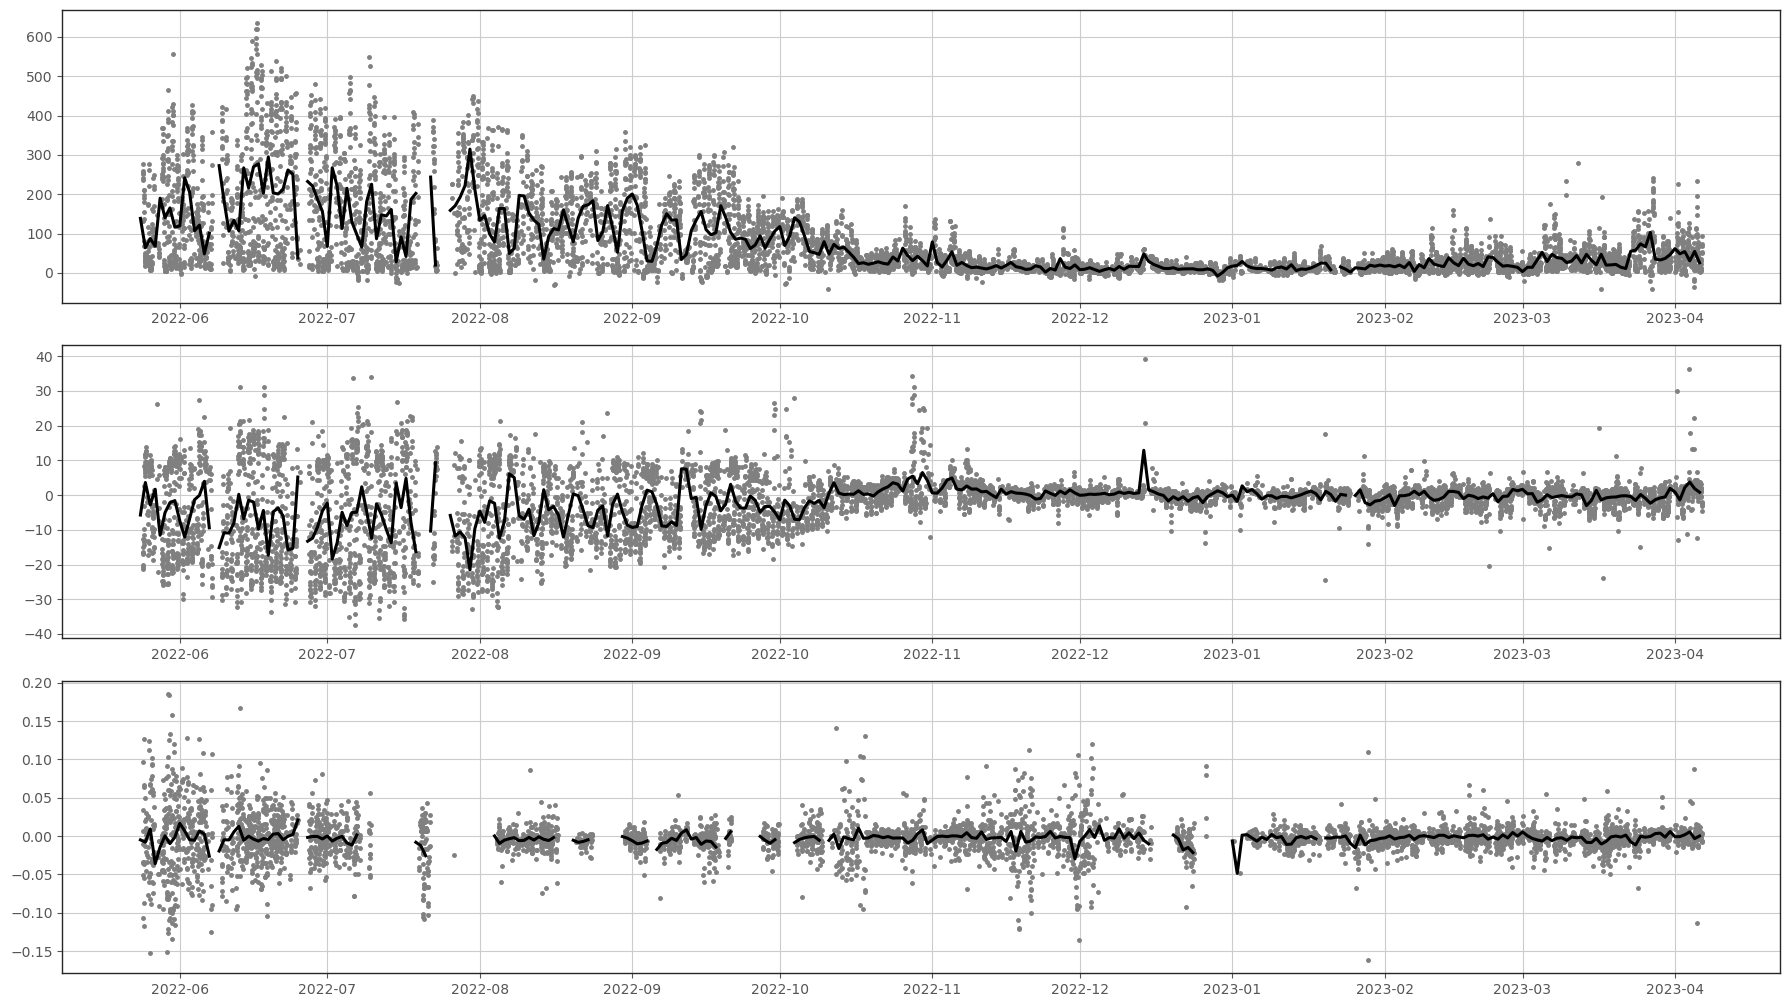

In [56]:
fig, ax = plt.subplots(3,1,figsize=(10*1.8, 5.65*1.8))

ax[0].plot(l3['LE'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[0].plot(daily['LE'], marker = '', lw = 2.2, color = 'k')

ax[1].plot(l3['co2_flux'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[1].plot(daily['co2_flux'], marker = '', lw = 2.2, color = 'k')

ax[2].plot(l3['ch4_flux'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[2].plot(daily['ch4_flux'], marker = '', lw = 2.2, color = 'k')

plt.tight_layout()

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_dailymean.png', dpi=300)


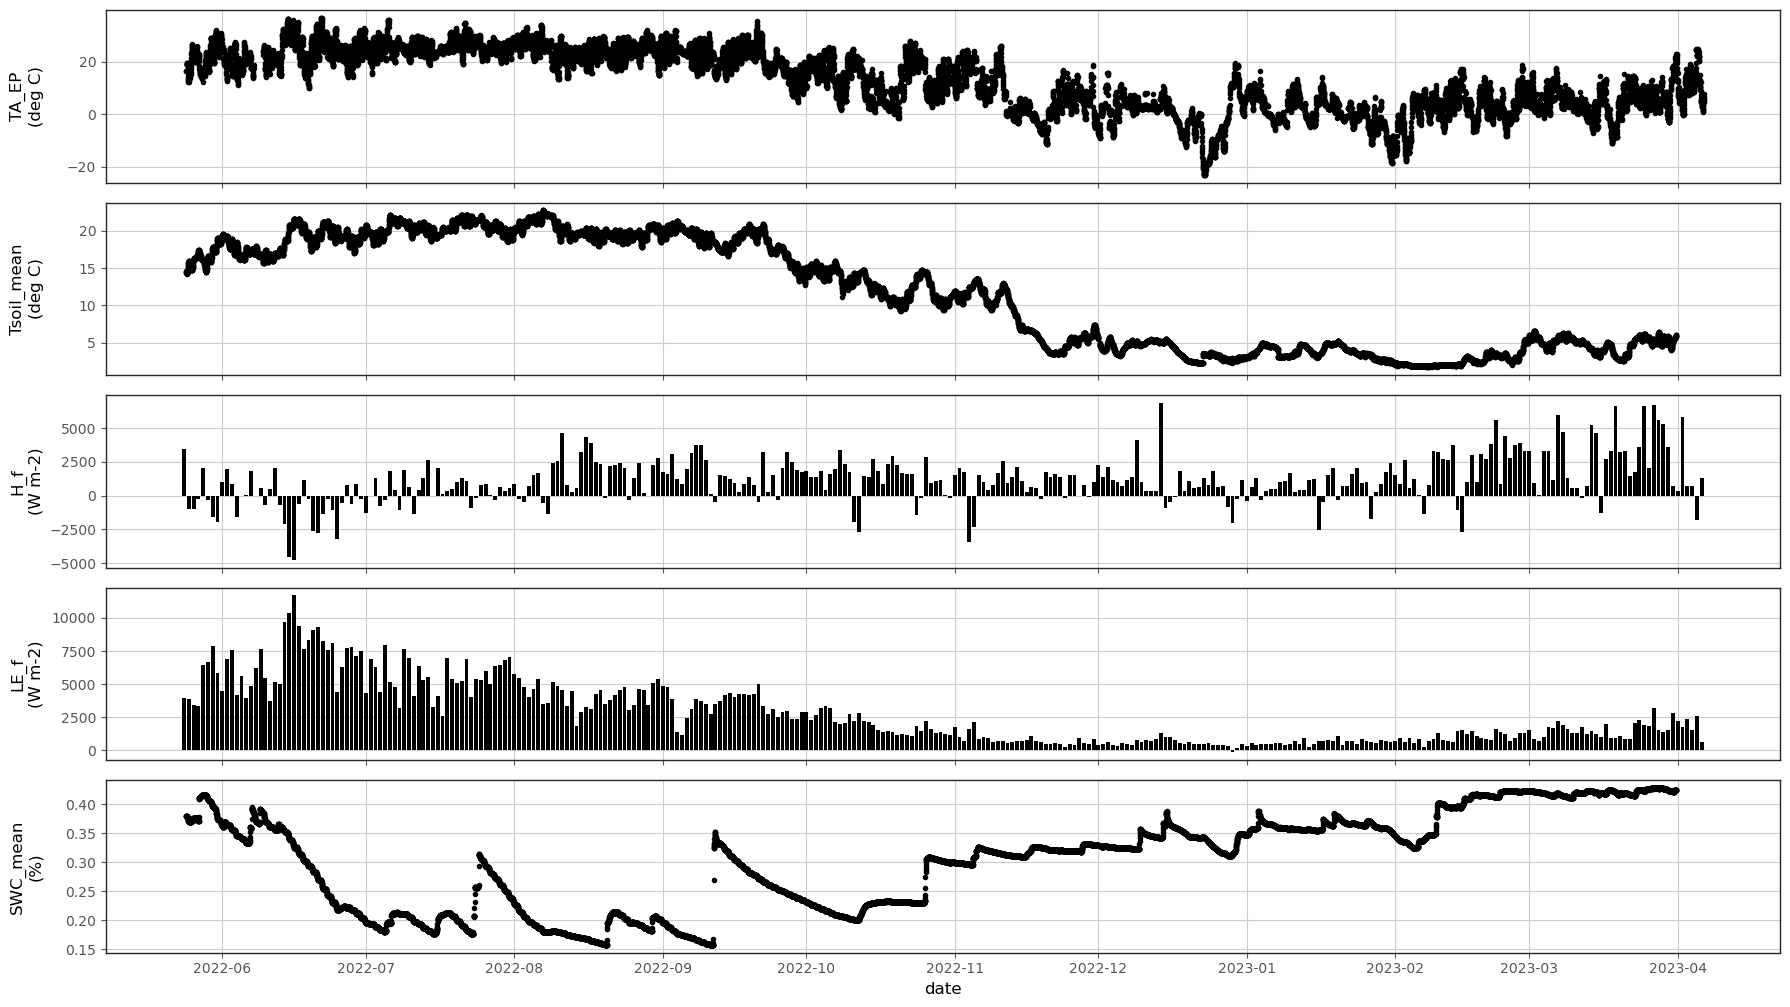

In [58]:
cols = ['TA_EP', 'Tsoil_mean', 'H_f', 'LE_f', 'SWC_mean']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].bar(dailysum.index, dailysum[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].plot(l3[cols[4]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(deg C)')
ax[2].set(ylabel = cols[2] + '\n(W m-2)')
ax[3].set(ylabel = cols[3] + '\n(W m-2)')
ax[4].set(ylabel = cols[4] + '\n(%)', xlabel = 'date')

plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3met_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

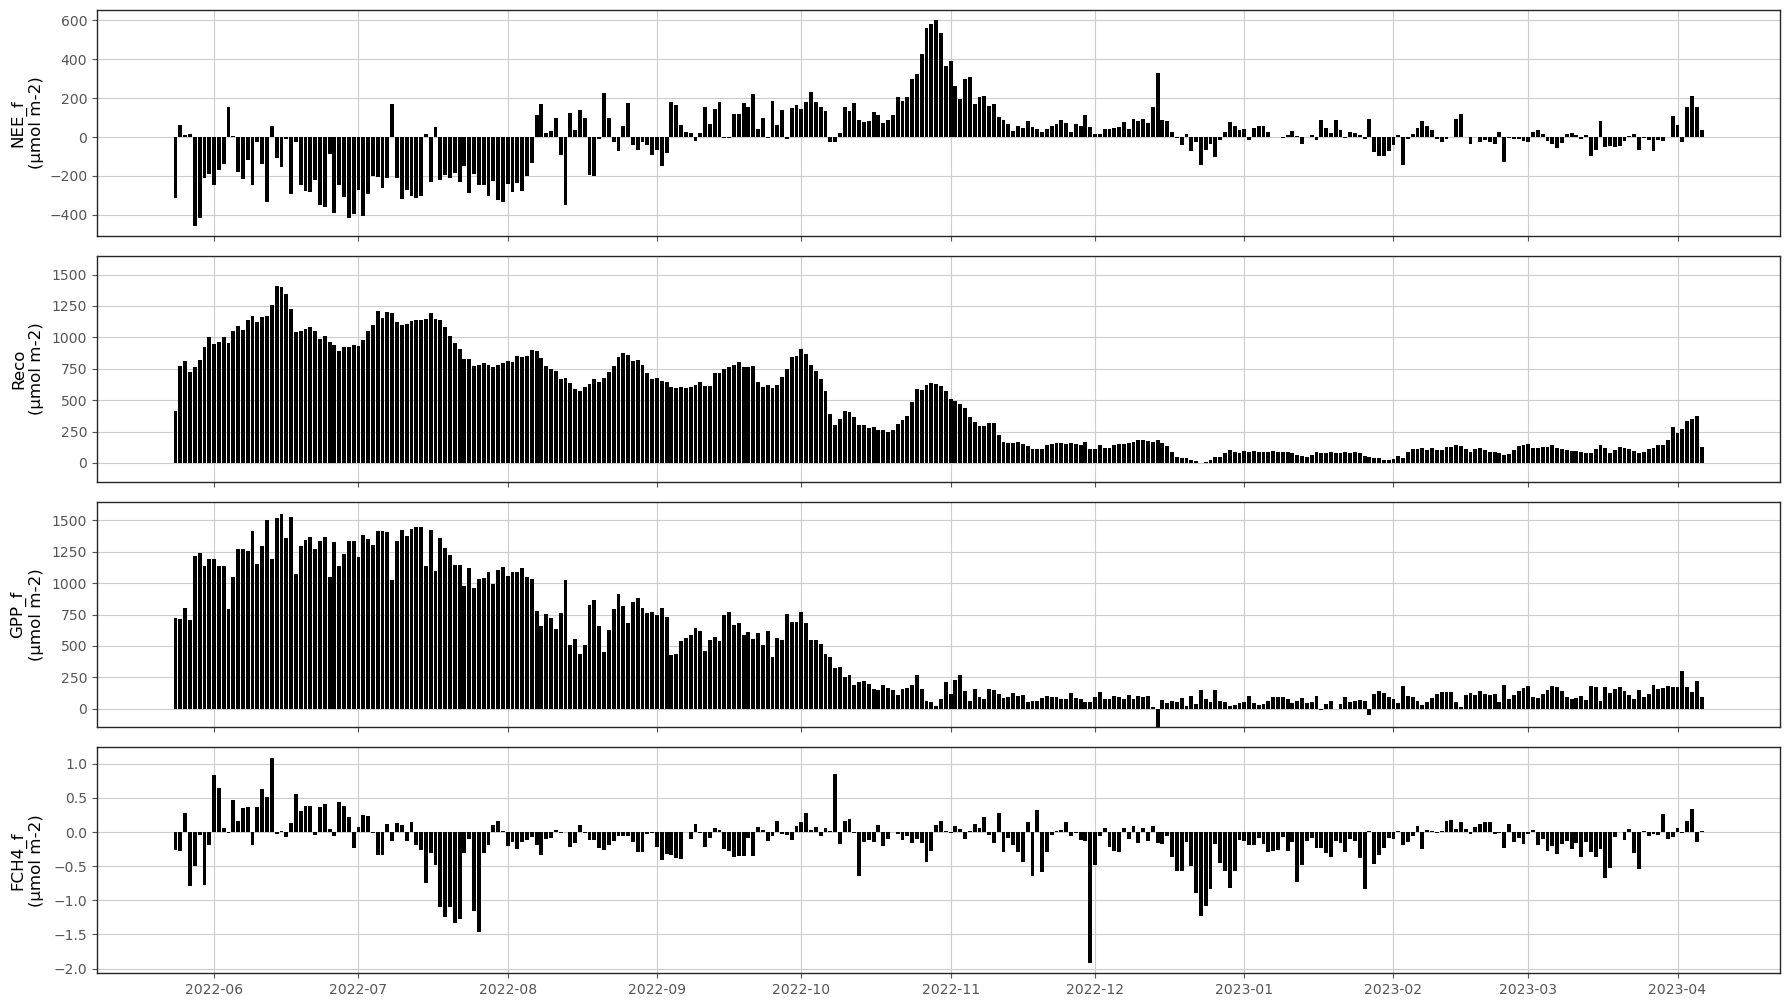

In [156]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')
    
ax[1].set(ylim = [-150,1650])
ax[2].set(ylim = [-150,1650])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_gapfilled.png', dpi=300)


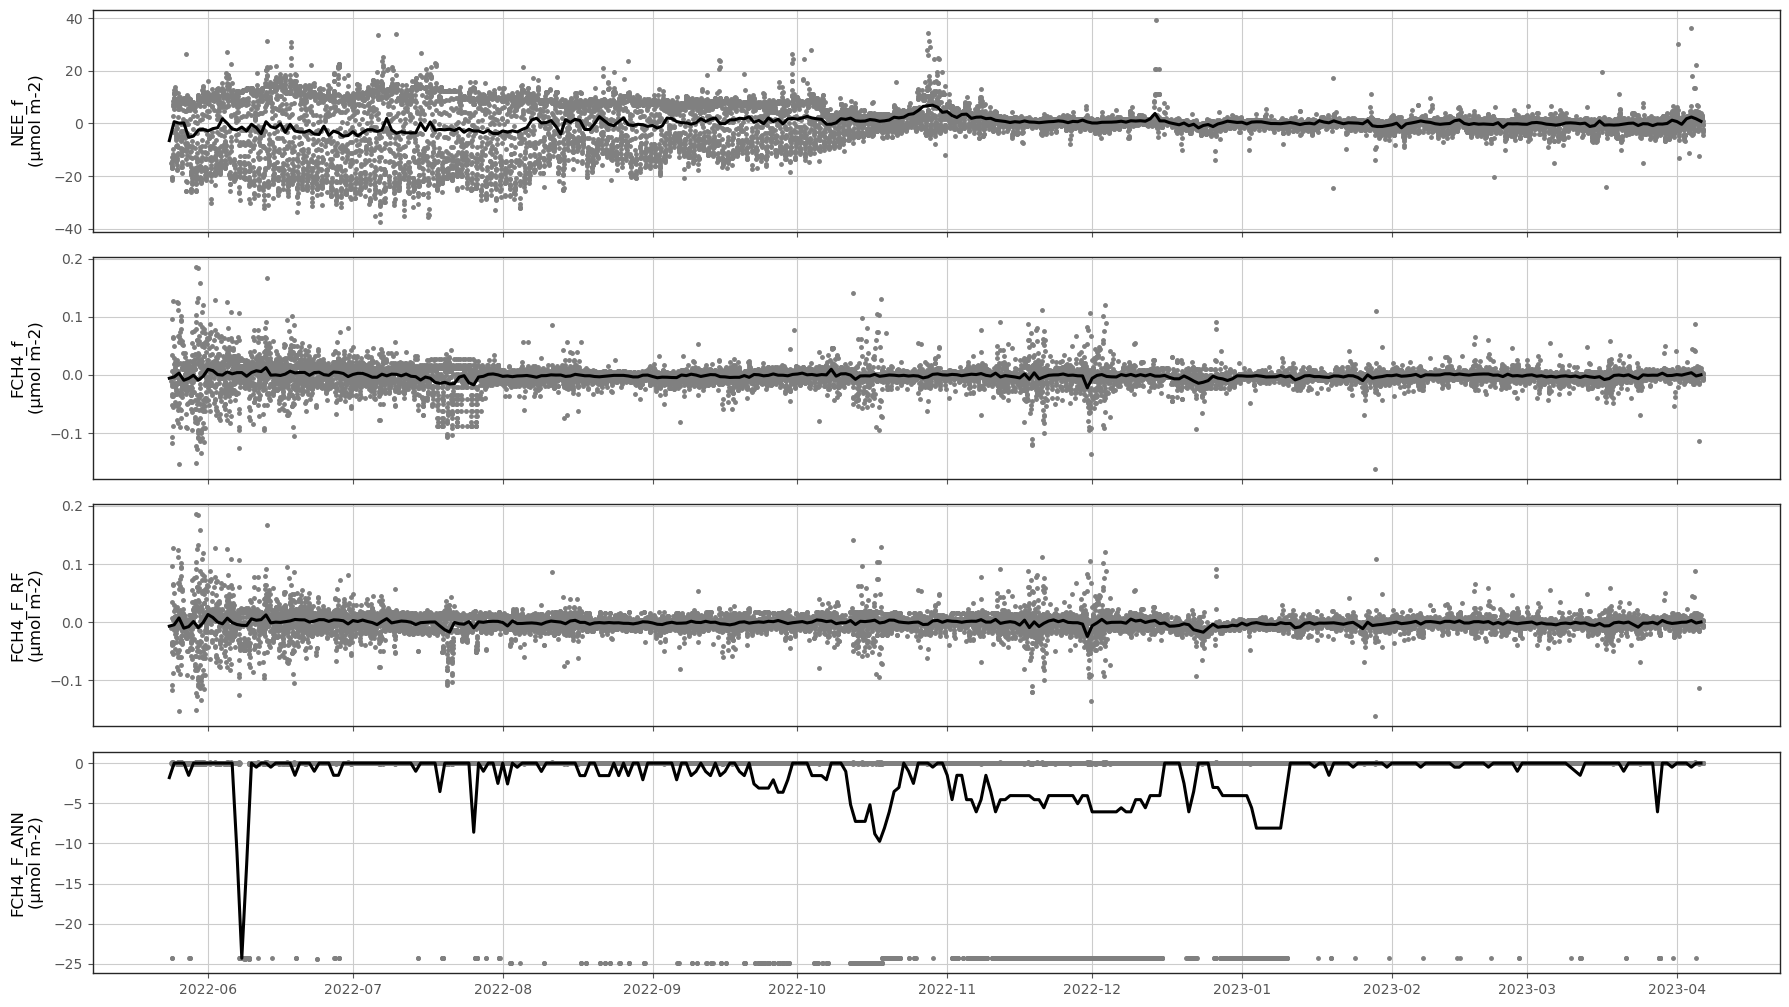

In [61]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].plot(l3[cols[i]], alpha = 1, ms = 5, ls = '', color = 'gray')
    ax[i].plot(daily[cols[i]], marker = '', lw = 2.2, color = 'k')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')


# ax[3].set(ylim=[-1000, 1000])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4models.png', dpi=300)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

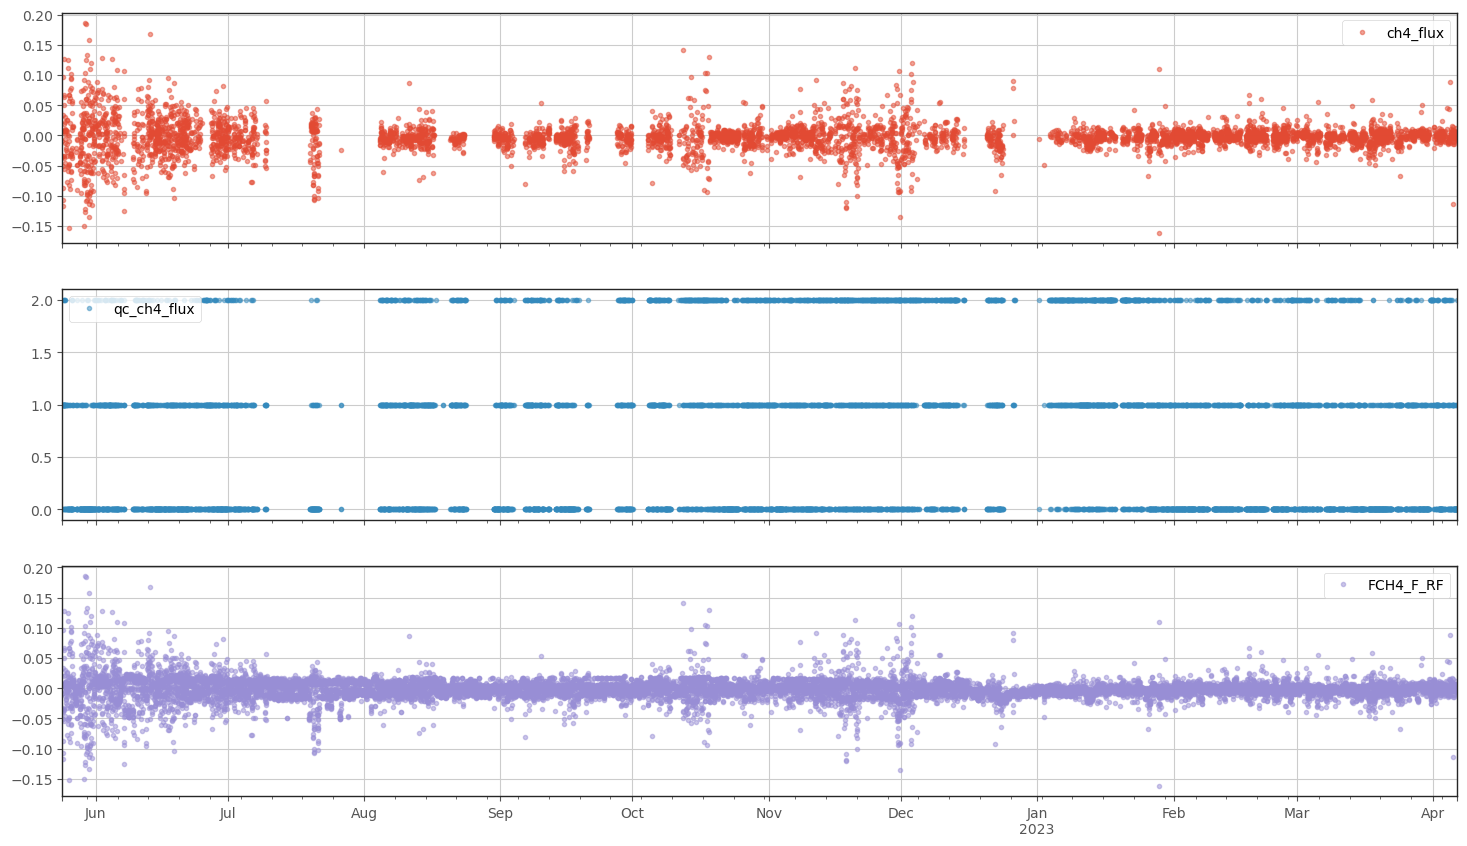

In [35]:
l3.loc[:, ['ch4_flux', 'qc_ch4_flux', 'FCH4_F_RF']].plot(subplots=True, linestyle='', alpha=0.5)

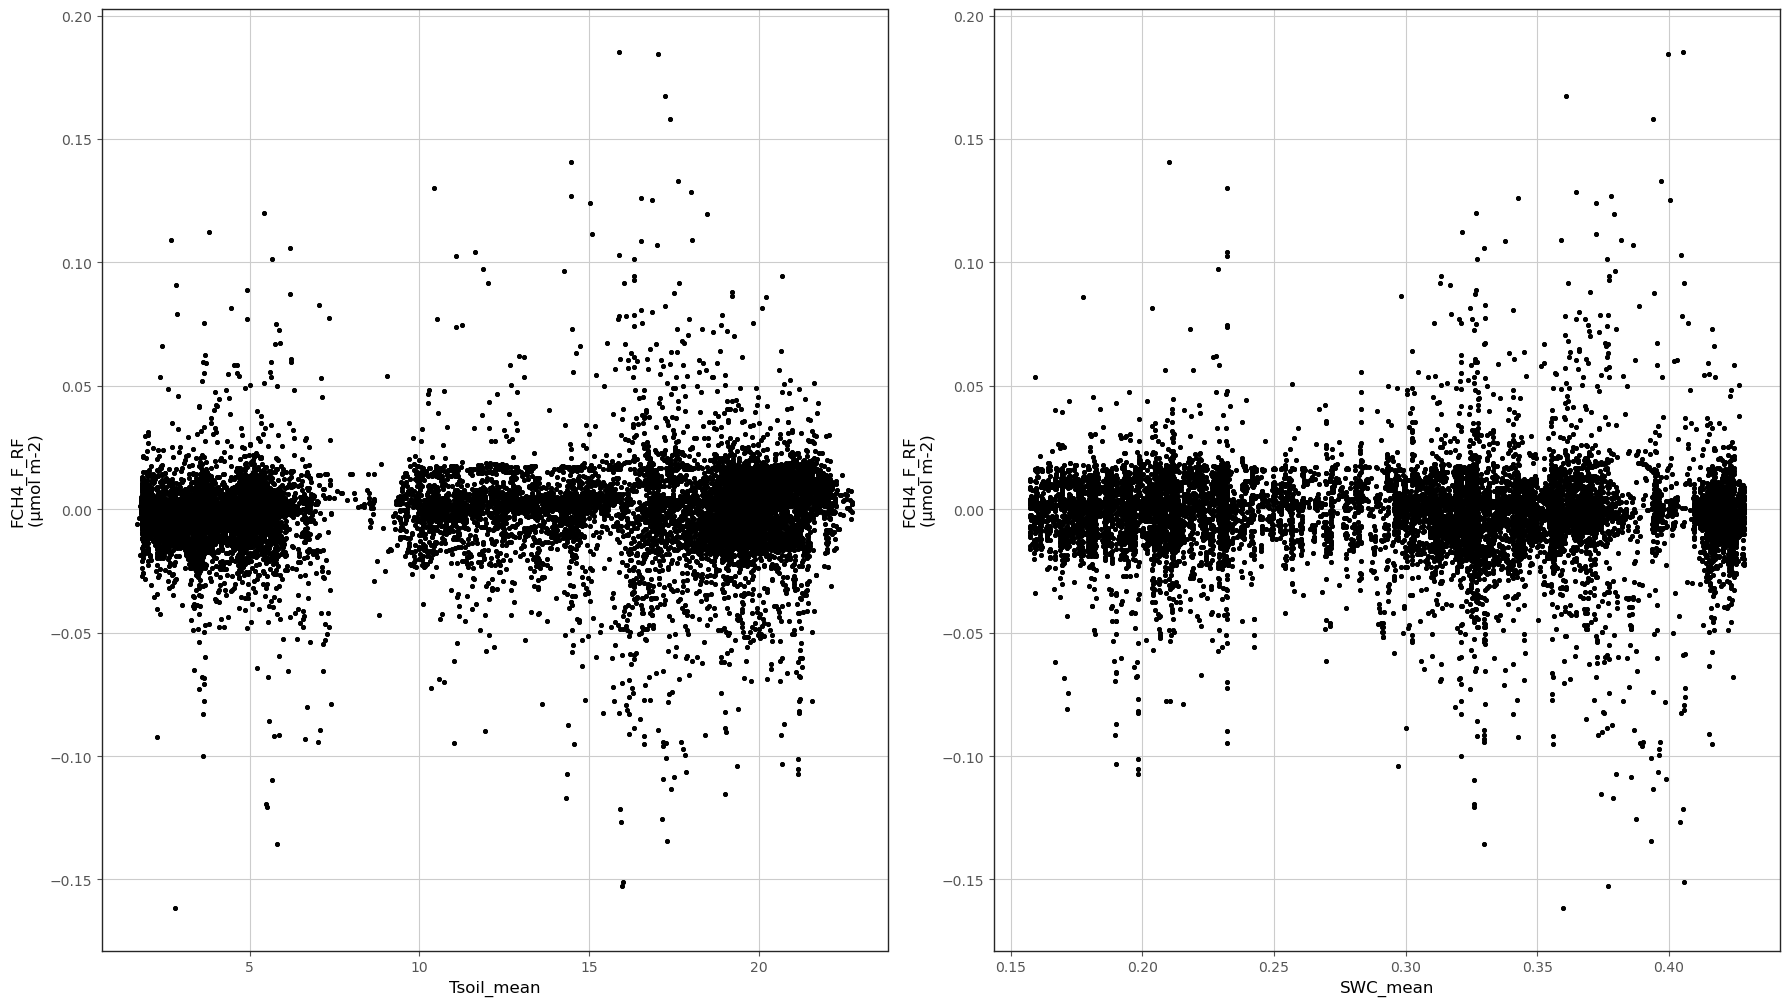

In [104]:
# cols = ['NEE_f', 'LE_f' 'FCH4_f', 'FCH4_F_RF']
cols = ['Tsoil_mean', 'SWC_mean']
fluxes = ['FCH4_f', 'FCH4_F_RF']
flux = fluxes[1]
fig, ax = plt.subplots(1,2)


for i in range(len(ax)):
    ax[i].plot(l3[cols[i]], l3[flux], ms = 5, ls='', color = 'k')
    ax[i].plot(l3[cols[i]], l3[flux], ms = 5, ls='', color = 'k')
    ax[i].set(xlabel = cols[i], ylabel = flux + '\n(µmol m-2)')
plt.tight_layout()
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_{flux}vsTsoilSWC.png', dpi=300)

<AxesSubplot:xlabel='Tsoil_mean', ylabel='SWC_mean'>

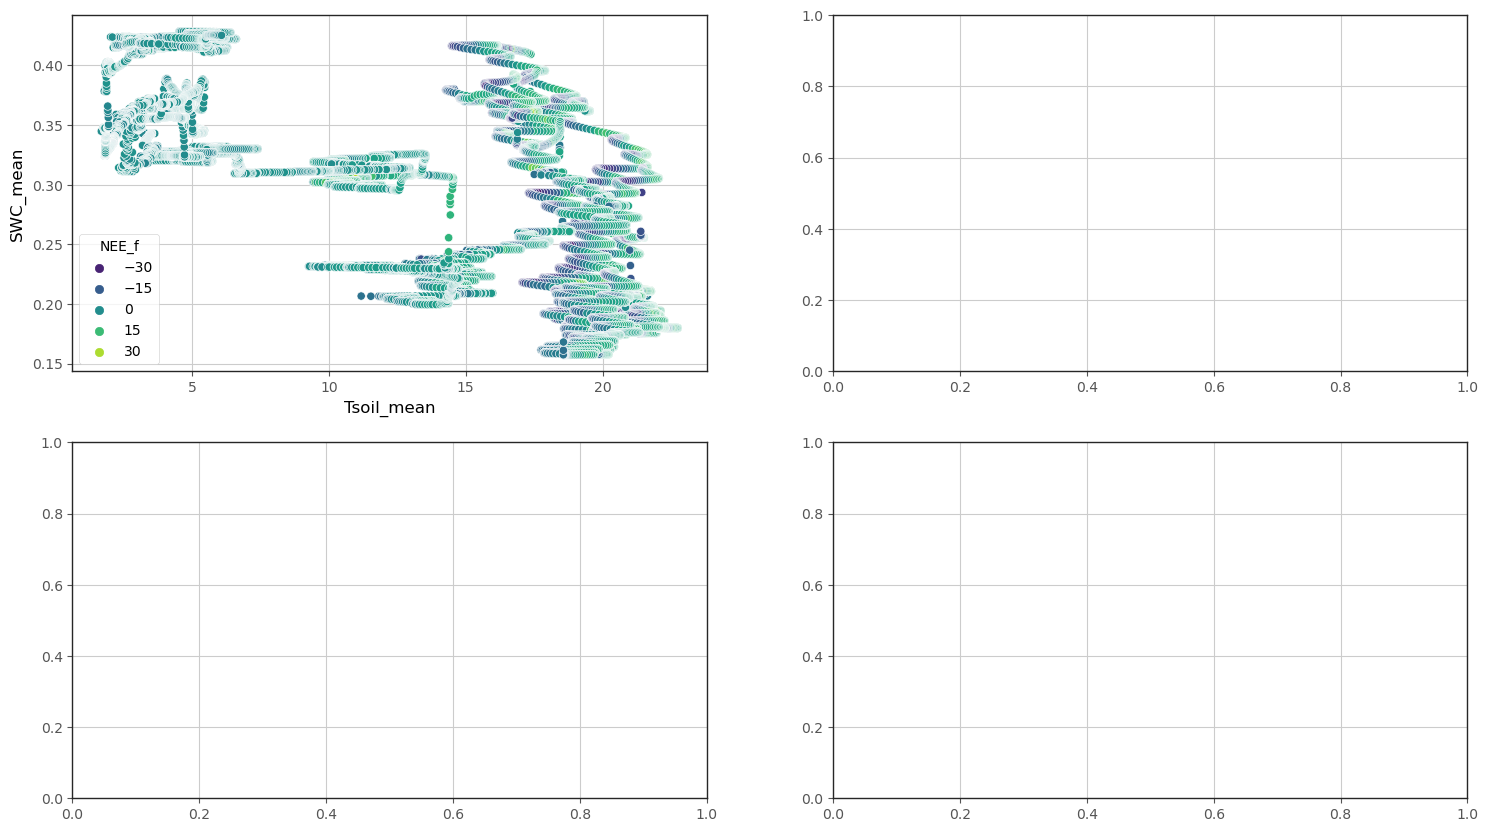

In [82]:
cols = ['NEE_f', 'LE_f' 'FCH4_f', 'FCH4_F_RF']

fig, ax = plt.subplots(2,2)

sns.scatterplot(data=l3, x = 'Tsoil_mean', y = 'SWC_mean', hue = cols[0], palette = 'viridis', ax = ax[0,0])

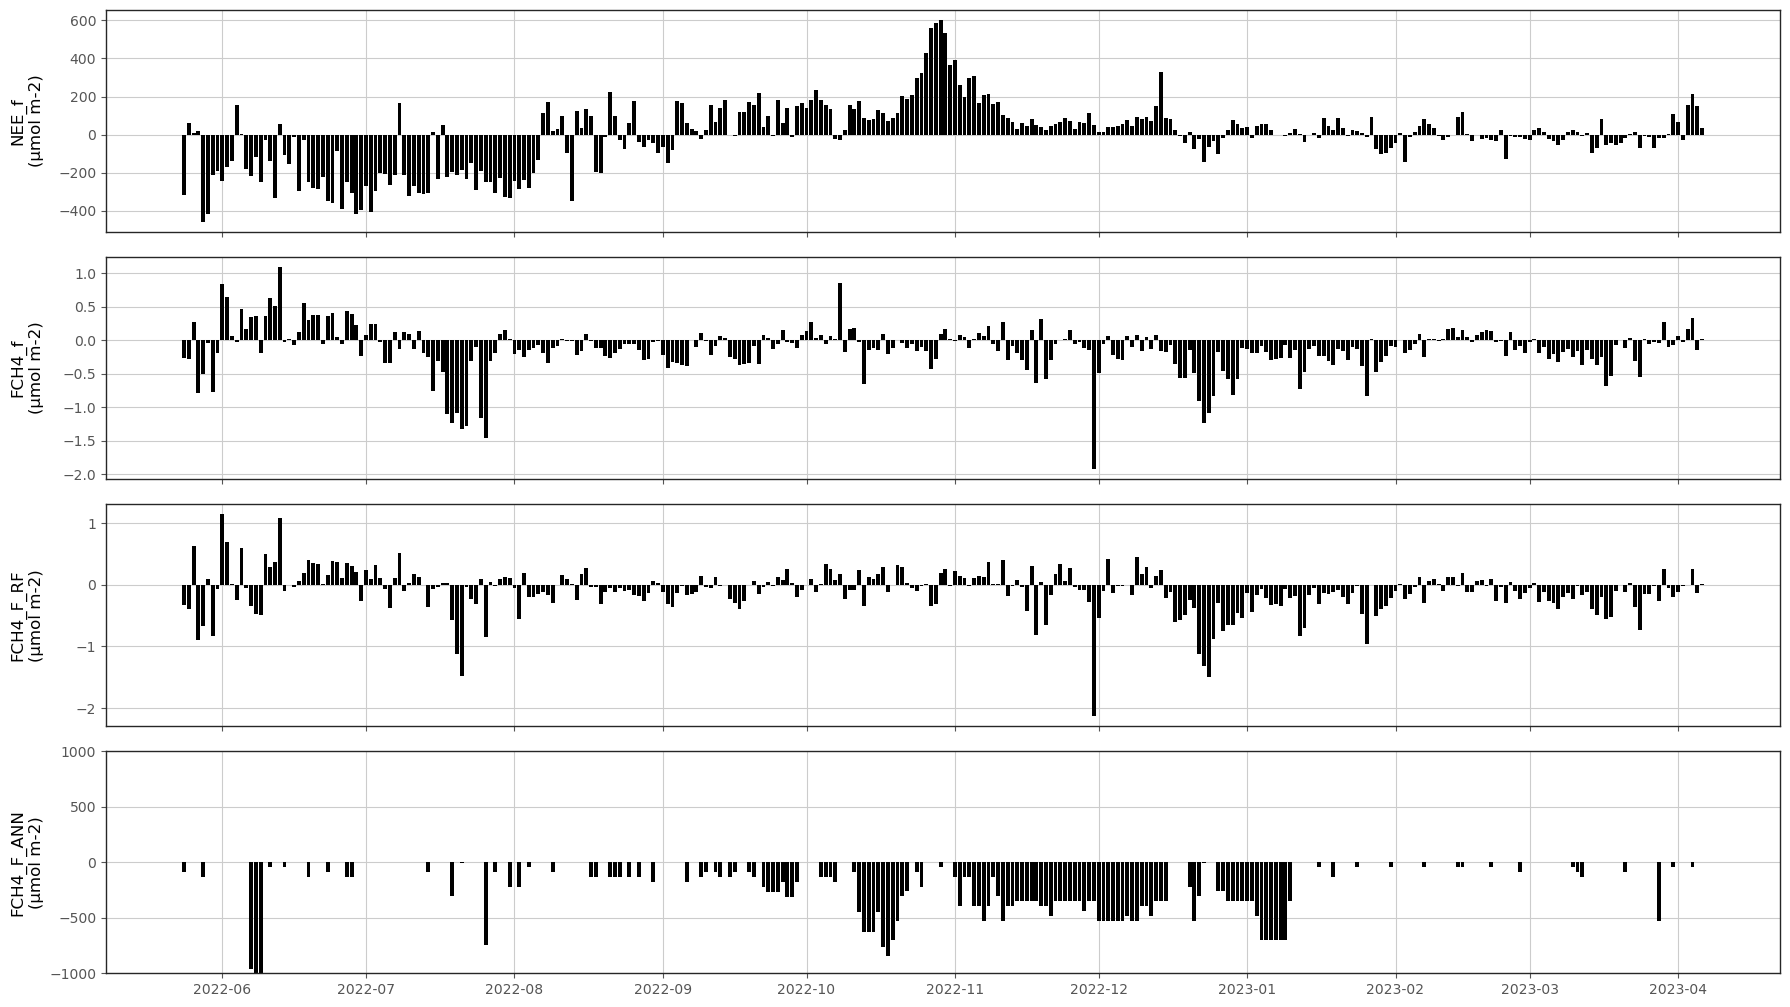

In [60]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')

ax[3].set(ylim=[-1000, 1000])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4modelsums.png', dpi=300)


## Plot methane-gapfill test results

In [67]:
project = 'ATMOS_20230425'

# predictors = ['baseline','basemet','basesoil','baseflux','basemetsoil','basefluxsoil','all']
predictors = ['baseline','basemet','basesoil','baseflux','basefluxvar', 'basemetsoil','basefluxsoil','all'] #0422
labels = ['baseline','+met','+soil','+flux', '+fluxvar', '+metsoil','+fluxsoil','all']

# predictors = ['baseline','basemet','basesoil','baseflux','basefluxvar'] #0425 for now
# labels = ['baseline','+met','+soil','+flux', '+fluxvar']

models = ['ann', 'rf']

tests = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/test_results.csv').assign(pred_subset = subset) for model in models for subset in predictors],
              ignore_index = True)

training = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/training_results.csv').assign(pred_subset = subset, model = model) for model in models for subset in predictors],
                    ignore_index = True)

# training[training['model']=='ann'].boxplot(column = ['nmae', 'pr2'], by='pred_subset')

In [80]:
tests.loc[(tests['model'].str.contains('rf')) & (tests['pred_subset'].str.match('baseflux')), :]

,mse,mae,nmae,r2,pr2,bias,calibration,sharpness,normalized_sharpness,calibration_scaled,sharpness_scaled,normalized_sharpness_scaled,site,model,predictors_subset,predictors,pred_subset
11,0.0006,0.0130,0.5425,0.0349,0.0517,0.0005,0.1982,0.0059,0.2479,0.9429,0.0880,3.6851,ATMOS_20230425_baseflux,rf,predictors,DOY;sin_DOY;cos_DOY;air_temperature;SW_IN_POT;...,baseflux
12,0.0006,0.0128,0.5354,0.0351,0.0515,0.0005,0.1786,0.0052,0.2162,0.9536,0.0820,3.4348,ATMOS_20230425_basefluxvar,rf,predictors,DOY;sin_DOY;cos_DOY;air_temperature;SW_IN_POT;...,basefluxvar
14,0.0006,0.0131,0.5476,0.0079,0.0392,0.0006,0.1607,0.0053,0.2207,0.9589,0.0858,3.5951,ATMOS_20230425_basefluxsoil,rf,predictors,DOY;sin_DOY;cos_DOY;air_temperature;SW_IN_POT;...,basefluxsoil


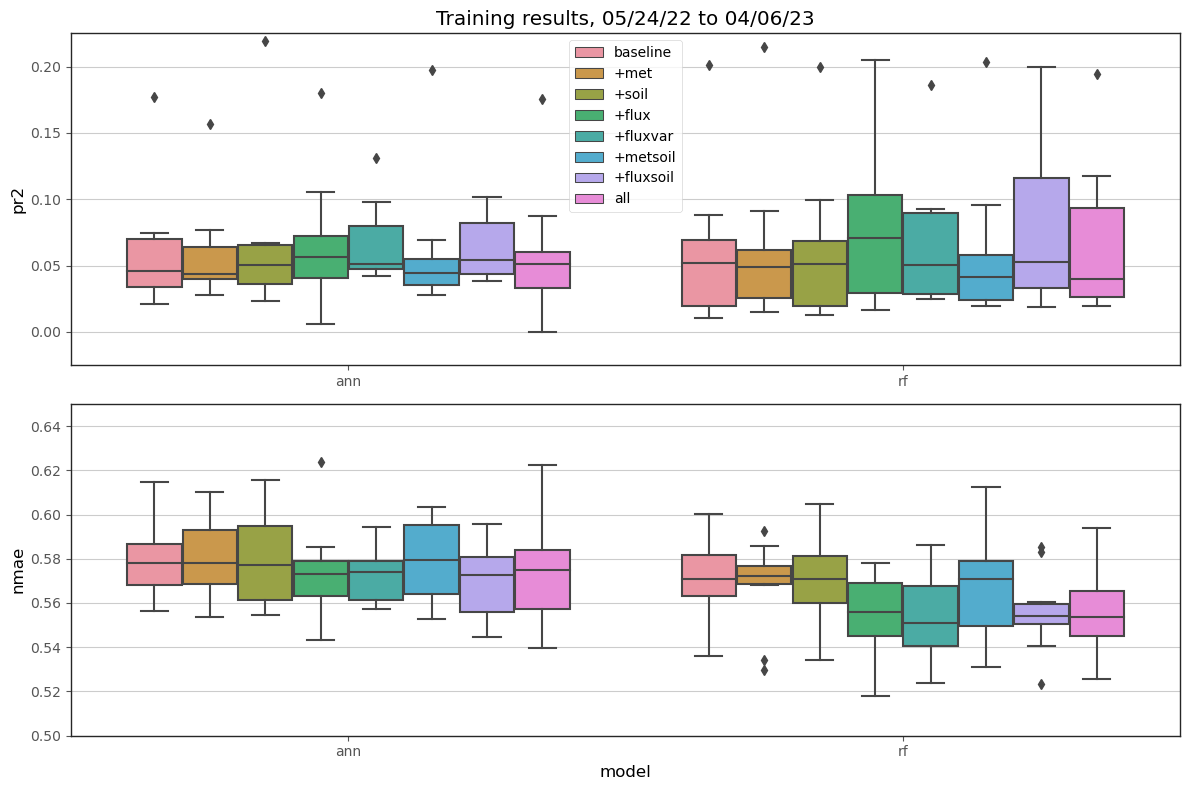

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(x='model', y='pr2', hue='pred_subset', data = training, ax = ax[0])
sns.boxplot(x='model', y='nmae', hue='pred_subset', data = training, ax = ax[1])

ax[1].get_legend().remove()
ax[0].set(ylim = [-0.025, 0.225], xlabel = '', title = 'Training results, 05/24/22 to 04/06/23')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles=h, labels=labels, loc='upper center')
ax[1].set(ylim = [0.5,0.65])
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_training0425.png', dpi=300)

/tmp/ipykernel_3152/3151985919.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
/tmp/ipykernel_3152/3151985919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)
/tmp/ipykernel_3152/3151985919.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels)


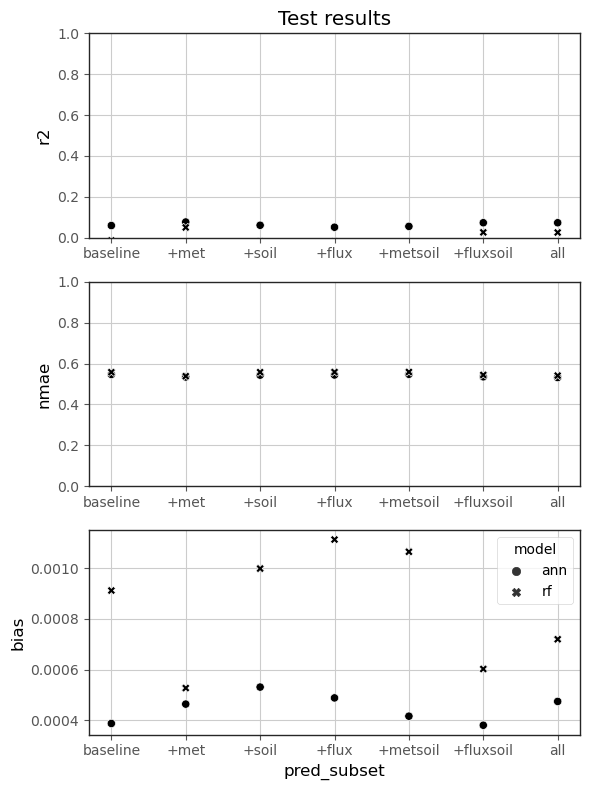

In [6]:
fig, ax = plt.subplots(3,1,figsize = (6, 8))
sns.scatterplot(x='pred_subset',y='r2',style='model', color = 'k', data = tests, ax = ax[0])
sns.scatterplot(x='pred_subset',y='nmae',style='model', color = 'k', data = tests, ax = ax[1])
sns.scatterplot(x='pred_subset',y='bias',style='model', color = 'k', data = tests, ax = ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set(ylim = [0,1], xlabel = None, title = 'Test results')
ax[1].set(ylim = [0,1], xlabel = None)
# ax[2].set(ylim = [0,1])
ax[0].set_xticklabels(labels)
ax[1].set_xticklabels(labels)
ax[2].set_xticklabels(labels)
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_tests.png', dpi=300)

In [87]:
mask1 = l3.columns.str.contains('G_')
mask2 = l3.columns.str.contains('RATIO')
mask3 = l3.columns.str.contains('LAG')
mask4 = l3.columns.str.contains('WD')
l3[l3.columns[mask4]]

,WD_FILTER_NR,WD,WD_SIGMA,WD_FILTER_NREX,WD60,WD_STD60,WD10,WD_STD10
date,,,,,,,,
2022-05-24 13:30:00,18000.0,247.8900,38.4218,0.0,89.0,0.0,63.2,28.9
2022-05-24 14:00:00,18000.0,253.6240,31.8325,0.0,NaN,NaN,NaN,NaN
2022-05-24 14:30:00,18000.0,249.2380,30.6542,0.0,777.7,777.7,72.8,21.9
2022-05-24 15:00:00,18000.0,253.4170,29.3374,0.0,NaN,NaN,NaN,NaN
2022-05-24 15:30:00,18000.0,249.4370,34.7957,0.0,60.9,13.8,71.1,14.6
...,...,...,...,...,...,...,...,...
2022-11-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30 22:30:00,18000.0,83.6459,16.4263,0.0,285.6,9.9,283.0,14.1
2022-11-30 23:00:00,18000.0,80.8154,16.0334,0.0,NaN,NaN,NaN,NaN


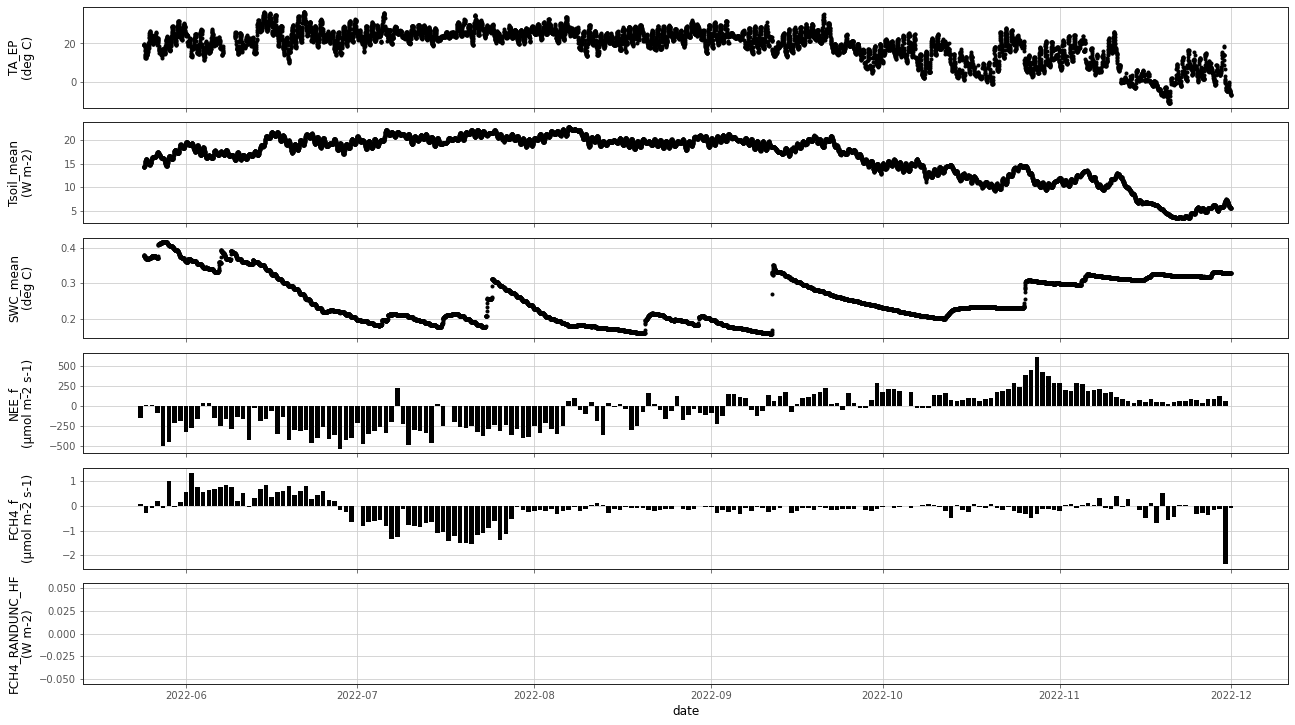

In [7]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'FCH4_RANDUNC_HF']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].plot(l3[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2 s-1)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2 s-1)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)

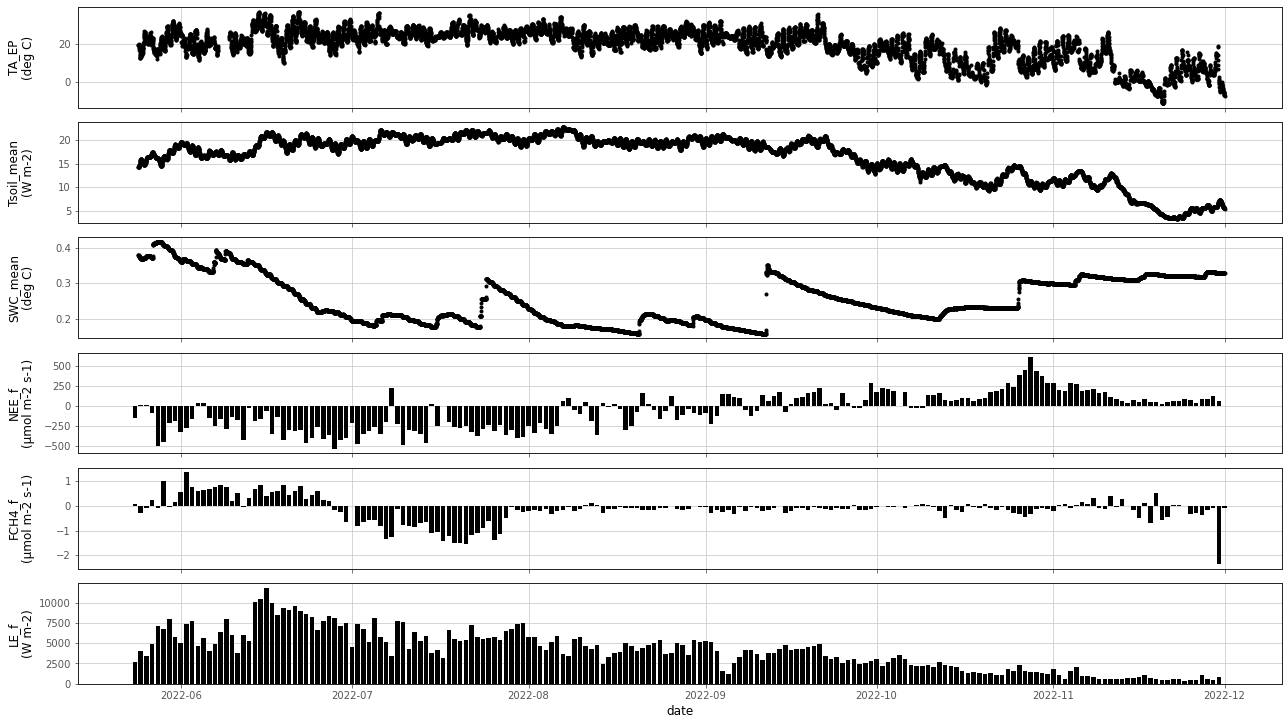

In [4]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'LE_f']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].bar(dailysum.index, dailysum[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)